In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'

# Transfer Learning on Cat vs. Dog Image Classification



## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2024-06-06 16:04:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   219MB/s    in 0.3s    

2024-06-06 16:04:53 (219 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.779.jpg', 'cat.589.jpg', 'cat.506.jpg', 'cat.942.jpg', 'cat.44.jpg', 'cat.584.jpg', 'cat.75.jpg', 'cat.276.jpg', 'cat.158.jpg', 'cat.724.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

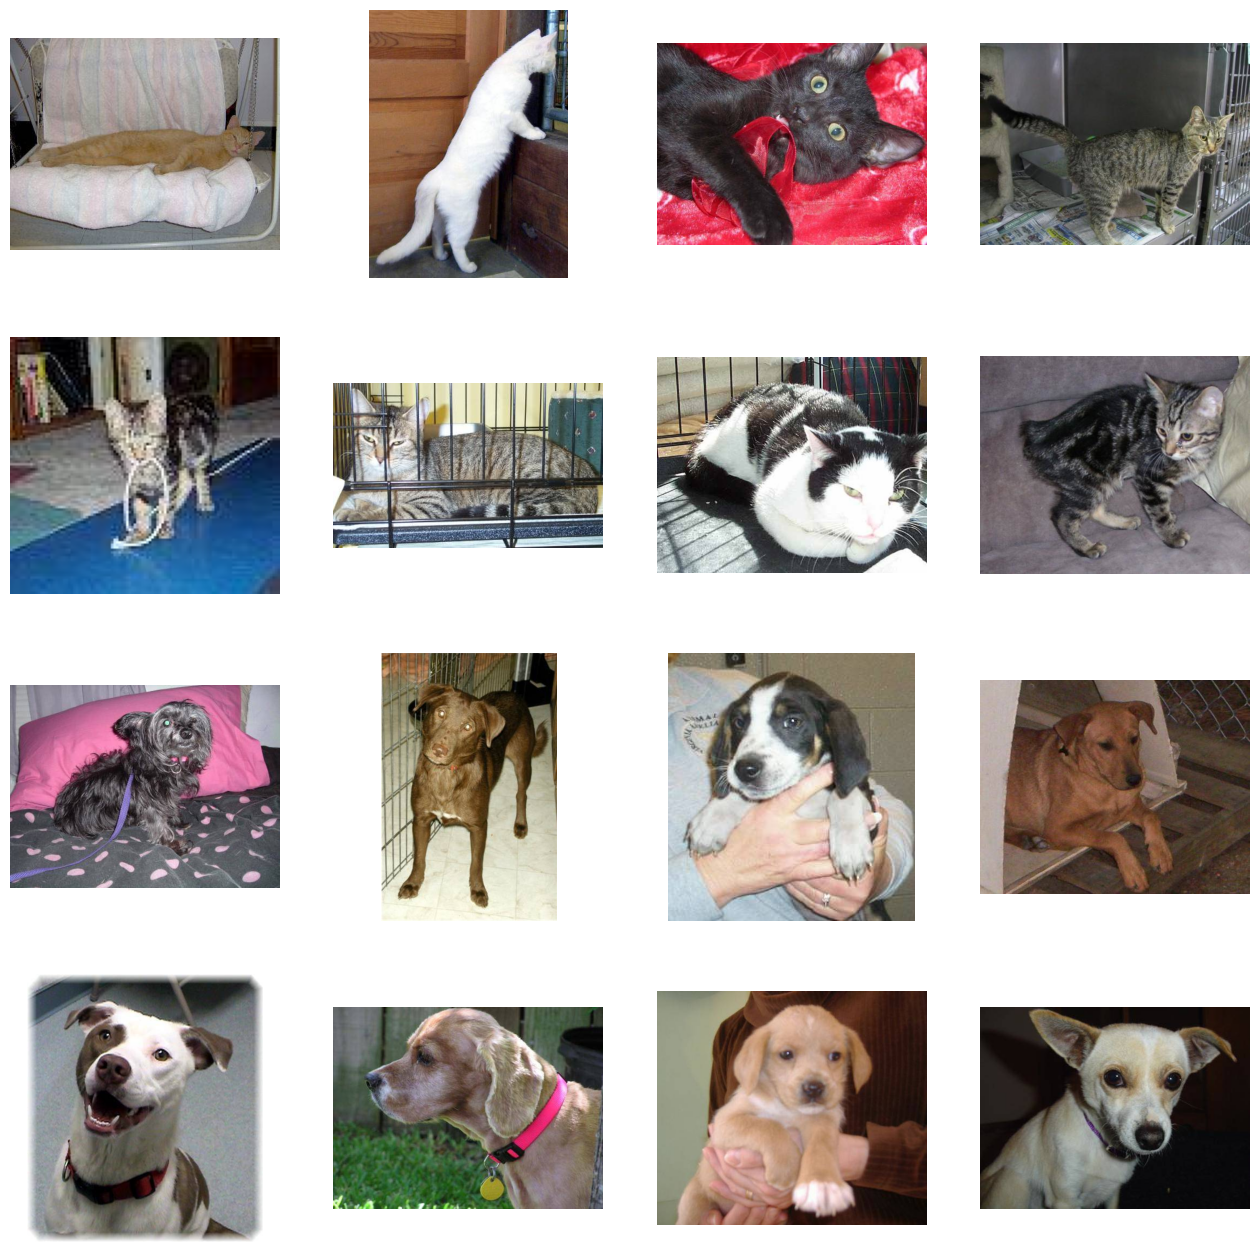

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a *binary classification problem*, we could  end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). In that case the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). But for the sake of generalitation to N classes, we will work with two output units and softmax.

## Use a large pre-trained model as base model

In [ ]:
from tensorflow.keras.applications import InceptionV3

IMG_SHAPE = (150, 150, 3)
# TODO 1: Download for keras applications inceptionV3 with 'imagenet weights'
# and without the top layer (softmax classification layer)
# Specify input_shape to IMG_SHAPE (150, 150, 3)
base_model = keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [ ]:
# Freeze the inceptionV3 (base_model) layers. This will prevent to change its
# weights when training the final classifier
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
# TODO 2: Complete the code to create your cat vs dog classifier using the base model.

# This will work by linking several pieces...
inputs = keras.Input(shape=(150, 150, 3))
inputs_rescaled = layers.Rescaling(1./255)(inputs)
# Connect your inputs as the inputs of the input model
x = base_model(inputs_rescaled)
# Now x contains the base model connected to the inputs. Note that the base model
# does not include a classification layer, so
x = layers.Flatten()(x)
# add your classification layer for cats and dogs connecting x as input
outputs = layers.Dense(1, activation='sigmoid')(x)
# finally, generate your new classification model
cnn_tl = keras.Model(inputs, outputs)

In [ ]:
cnn_tl.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 18433     
                                                                 
Total params: 21821217 (83.24 MB)
Trainable params: 18433 (72.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
cnn_tl.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
# if you correctly did the steps above, you should see an impressive 0.9X accuracy in both
# training and validation sets
history_with_tl = cnn_tl.fit(train_dataset, epochs=15, validation_data=validation_dataset, verbose=2)

Epoch 1/15
63/63 - 11s - loss: 0.2852 - acc: 0.8915 - val_loss: 0.1702 - val_acc: 0.9320 - 11s/epoch - 169ms/step
Epoch 2/15
63/63 - 4s - loss: 0.1131 - acc: 0.9575 - val_loss: 0.1290 - val_acc: 0.9470 - 4s/epoch - 56ms/step
Epoch 3/15
63/63 - 4s - loss: 0.0707 - acc: 0.9745 - val_loss: 0.1139 - val_acc: 0.9520 - 4s/epoch - 58ms/step
Epoch 4/15
63/63 - 5s - loss: 0.0496 - acc: 0.9845 - val_loss: 0.1402 - val_acc: 0.9460 - 5s/epoch - 79ms/step
Epoch 5/15
63/63 - 4s - loss: 0.0343 - acc: 0.9880 - val_loss: 0.1798 - val_acc: 0.9400 - 4s/epoch - 57ms/step
Epoch 6/15
63/63 - 4s - loss: 0.0261 - acc: 0.9925 - val_loss: 0.1105 - val_acc: 0.9570 - 4s/epoch - 59ms/step
Epoch 7/15
63/63 - 5s - loss: 0.0141 - acc: 0.9980 - val_loss: 0.1244 - val_acc: 0.9510 - 5s/epoch - 76ms/step
Epoch 8/15
63/63 - 4s - loss: 0.0111 - acc: 0.9995 - val_loss: 0.1098 - val_acc: 0.9620 - 4s/epoch - 57ms/step
Epoch 9/15
63/63 - 5s - loss: 0.0088 - acc: 0.9985 - val_loss: 0.1194 - val_acc: 0.9600 - 5s/epoch - 72ms/ste